In [2]:
import glob
import os
import pandas as pd
import seaborn as snsß
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import seaborn as sns
import pandas as pd
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
from algos.alg_fpd_predictor import FpdPredictor
import numpy as np
from bitarray import bitarray, util, bits2bytes
import tqdm
import struct
from shapely.geometry import shape
from collections import defaultdict
import math
import random
from algos.fpd_extended_lib.compress import *


100%|██████████| 10259/10259 [00:06<00:00, 1543.67it/s]


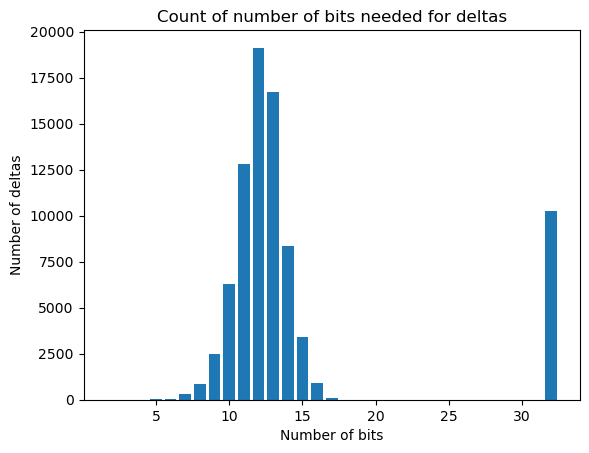

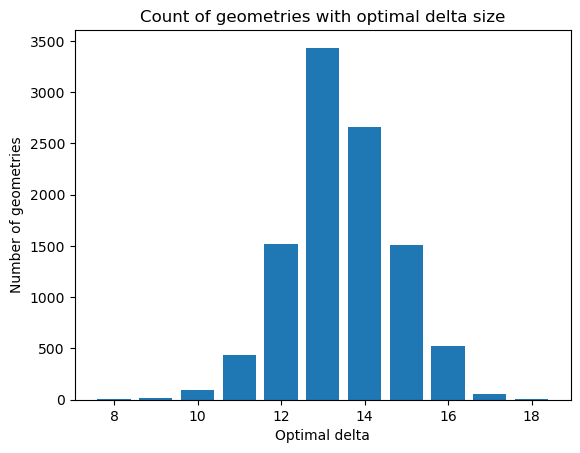

In [3]:
fpd = FpdExtended()

import bench_utils
df, unary_idxs = bench_utils.read_dataset("data/lund_building_highway.json")
unary_idxs = list(set(unary_idxs))
bins = []

tot_bit_count = defaultdict(int)
opt_size_distribution = defaultdict(int)
deltas_fp = []
deltas_long = []
# Compress files, benchmark unaries
for idx in tqdm.tqdm(unary_idxs): # List of single idxs
    opt_size, bit_count, deltas = calculate_delta_size(shape(df.iloc[idx]), True)
    deltas_fp += deltas[0]
    deltas_long += deltas[1]
    for bit_count_key in bit_count:
        tot_bit_count[bit_count_key] += bit_count[bit_count_key]
    opt_size_distribution[opt_size] += 1
    bins.append(fpd.compress(shape(df.iloc[idx]))[1])
plt.bar(tot_bit_count.keys(), tot_bit_count.values());
plt.title("Count of number of bits needed for deltas")
plt.xlabel("Number of bits")
plt.ylabel("Number of deltas")
plt.show()

plt.bar(opt_size_distribution.keys(), opt_size_distribution.values());
plt.title("Count of geometries with optimal delta size")
plt.xlabel("Optimal delta")
plt.ylabel("Number of geometries")
plt.show()
deltas_fp = np.array(deltas_fp)

Percentage of total FP deltas within filtered 0.7848072590125392
Percentage of total FP deltas (but removed excessive values) within filtered 0.8975631958546321
Percentage of total LONG + ZZ deltas within filtered 0.8513788205329154
Percentage of total LONG + ZZ deltas (but removed excessive values) within filtered 0.8513788205329154


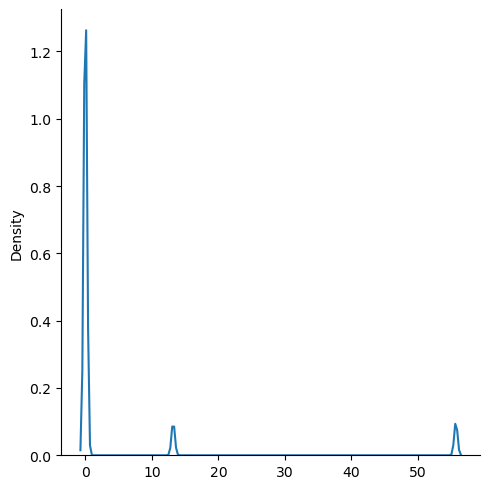

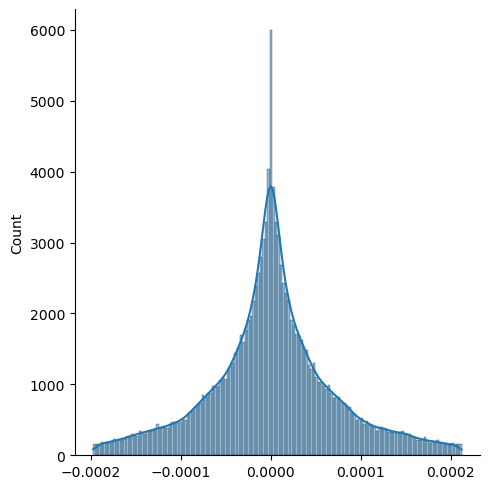

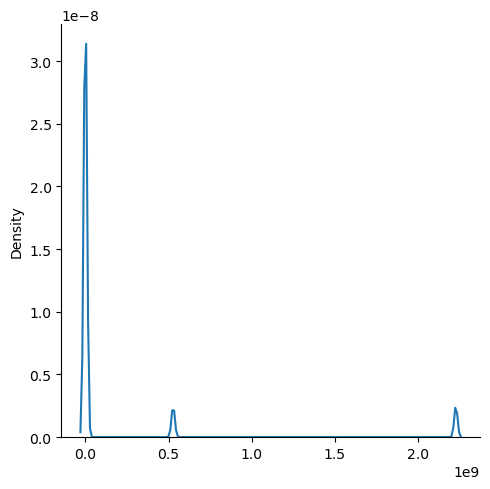

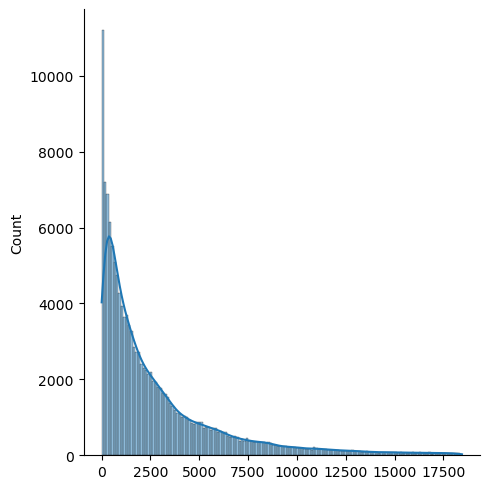

In [4]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

OUTLIER_THRESHOLD = 2.5
filtered = np.array(deltas_fp)
filtered = filtered[~is_outlier(filtered, thresh=OUTLIER_THRESHOLD)]
sns.displot(deltas_fp, kind="kde", bw_adjust=.2)
#sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total FP deltas within filtered", len(filtered) / len(deltas_fp))
print("Percentage of total FP deltas (but removed excessive values) within filtered", len(filtered) / len(deltas_fp[deltas_fp < 10]))

OUTLIER_THRESHOLD = 6
deltas_long_np = np.array(deltas_long, dtype=np.float64)
filtered = np.array(deltas_long_np)
filtered = filtered[~is_outlier(filtered, thresh=OUTLIER_THRESHOLD)]
sns.displot(deltas_long_np, kind="kde", bw_adjust=.2)
#sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total LONG + ZZ deltas within filtered", len(filtered) / len(deltas_long_np))
print("Percentage of total LONG + ZZ deltas (but removed excessive values) within filtered", len(filtered) / len(deltas_long_np[deltas_long_np < 4 * pow(10, 18)]))

In [5]:
for i in range(1):
    idx = random.randint(0, len(deltas_fp))
    print("---")
    print("Delta in FP and LONG:    ", f'{deltas_fp[idx]:.14f}', '        ', deltas_long[idx])
    print("Converting to f32:       ", f'{struct.unpack("!f", struct.pack("!f", deltas_fp[idx]))[0]:.14f}')
    print("Required bits:           ", math.ceil(math.log2(deltas_long[idx] + 1)))
    bin = util.int2ba(deltas_long[idx], length=64)
    print("ZZ-encoded:              ", end=None)
    util.pprint(bin, width=200)

    bin = bitarray()
    print("FP directly to bin:      ", end=None)
    bin.frombytes(struct.pack("!d", deltas_fp[idx]))
    util.pprint(bin, width=200)

    bin = bitarray()
    print("FP32 directly to bin:    ", end=None)
    bin.frombytes(struct.pack("!f", deltas_fp[idx]))
    
    util.pprint(bin, width=200)

---
Delta in FP and LONG:     13.21667760000000          528667104
Converting to f32:        13.21667766571045
Required bits:            29
ZZ-encoded:              
bitarray('00000000 00000000 00000000 00000000 00011111 10000010 11010001 11100000')
FP directly to bin:      
bitarray('01000000 00101010 01101110 11110000 01011101 11001011 10001101 00110010')
FP32 directly to bin:    
bitarray('01000001 01010011 01110111 10000011')


## Entrpoy Encoding Analysis

In [6]:
#Created stats variables for all deltas in general, per defined optimal size and per geometry
global_delta_frequencies = []
global_delta_freq_by_opt_size = defaultdict(list)
delta_freq_by_geometry = defaultdict(list)

In [7]:
#Fill list of previous variables
for idx in tqdm.tqdm(unary_idxs): # List of single idxs
    opt_size, bit_count, deltas = calculate_delta_size(shape(df.iloc[idx]), True)
    for delta in deltas[1]:
        if delta != 0 and math.log2(delta) > opt_size:
            continue
        global_delta_frequencies.append(delta)
        global_delta_freq_by_opt_size[opt_size].append(delta)
        delta_freq_by_geometry[idx].append(delta)

100%|██████████| 10259/10259 [00:02<00:00, 4218.42it/s]


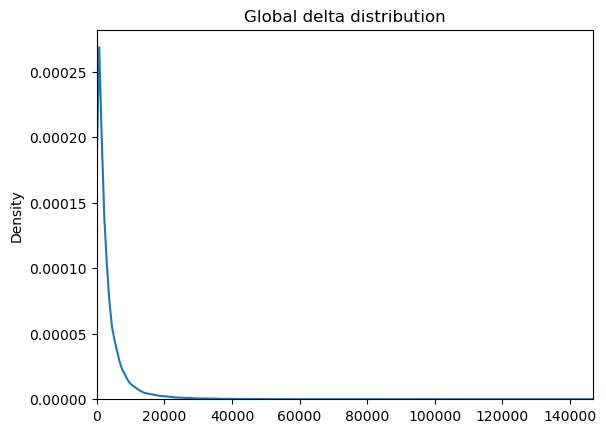

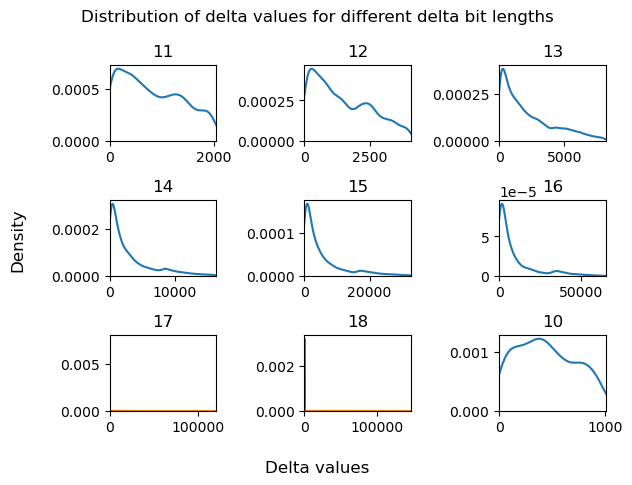

In [8]:
plt.title("Global delta distribution")
ax = sns.kdeplot(global_delta_frequencies)
ax.set_xlim(0, max(global_delta_frequencies))
plt.show()

HEIGHT, WIDTH = 3,3
fig, axes = plt.subplots(WIDTH, HEIGHT)

for idx, os in enumerate(sorted(global_delta_freq_by_opt_size.keys())):
    axes[idx // WIDTH - 1,idx % HEIGHT].set_title(os)
    ax = sns.kdeplot(global_delta_freq_by_opt_size[os], ax=axes[idx // WIDTH - 1,idx % HEIGHT])
    axes[idx // WIDTH - 1,idx % HEIGHT].set_xlim(0, max(global_delta_freq_by_opt_size[os]))
    axes[idx // WIDTH - 1,idx % HEIGHT].set(ylabel=None)

fig.supylabel('Density')
fig.supxlabel('Delta values')
fig.suptitle('Distribution of delta values for different delta bit lengths')
plt.tight_layout()

plt.show()

#### Delta prefix analysis

In [32]:
PREFIX_LENGTH = 6
def calculate_prefix_counts(prefix_len):
    bit_counts_per_opt_size = defaultdict(dict)
    global_bit_counts = defaultdict(int)
    for opt_size in tqdm.tqdm(global_delta_freq_by_opt_size):
        deltas = global_delta_freq_by_opt_size[opt_size]
        for d in deltas:
            bits = uint_to_ba(d,opt_size)
            prefix_bits = bits[:prefix_len].to01()
            # for i in range(len(bits)):
            #     for j in range(i + 1,len(bits)):
            global_bit_counts[prefix_bits] += 1
            if prefix_bits in bit_counts_per_opt_size[opt_size]:
                bit_counts_per_opt_size[opt_size][prefix_bits] += 1
            else:
                bit_counts_per_opt_size[opt_size][prefix_bits] = 1
    return bit_counts_per_opt_size, global_bit_counts


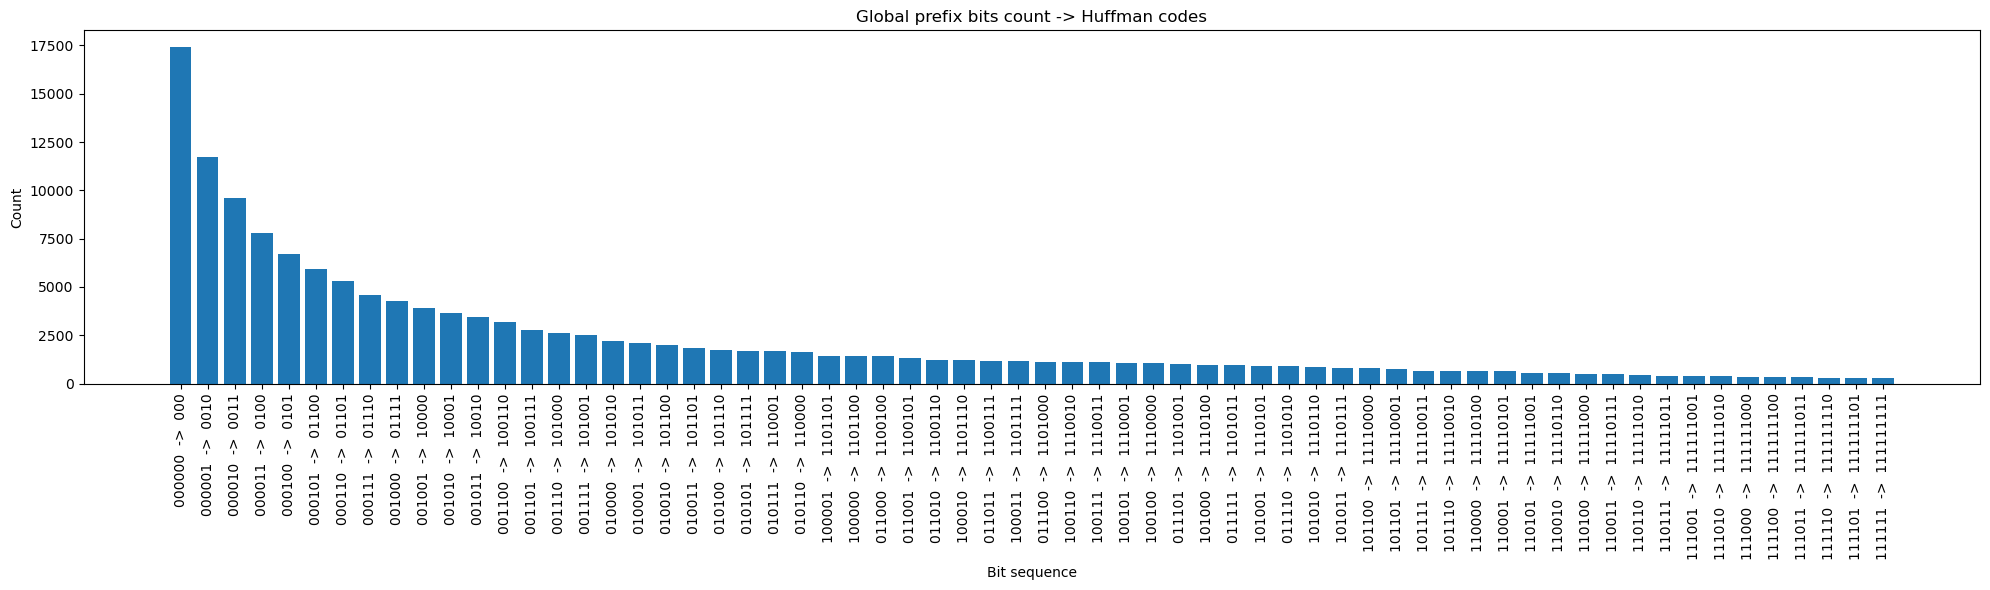

11it [00:01,  9.76it/s]


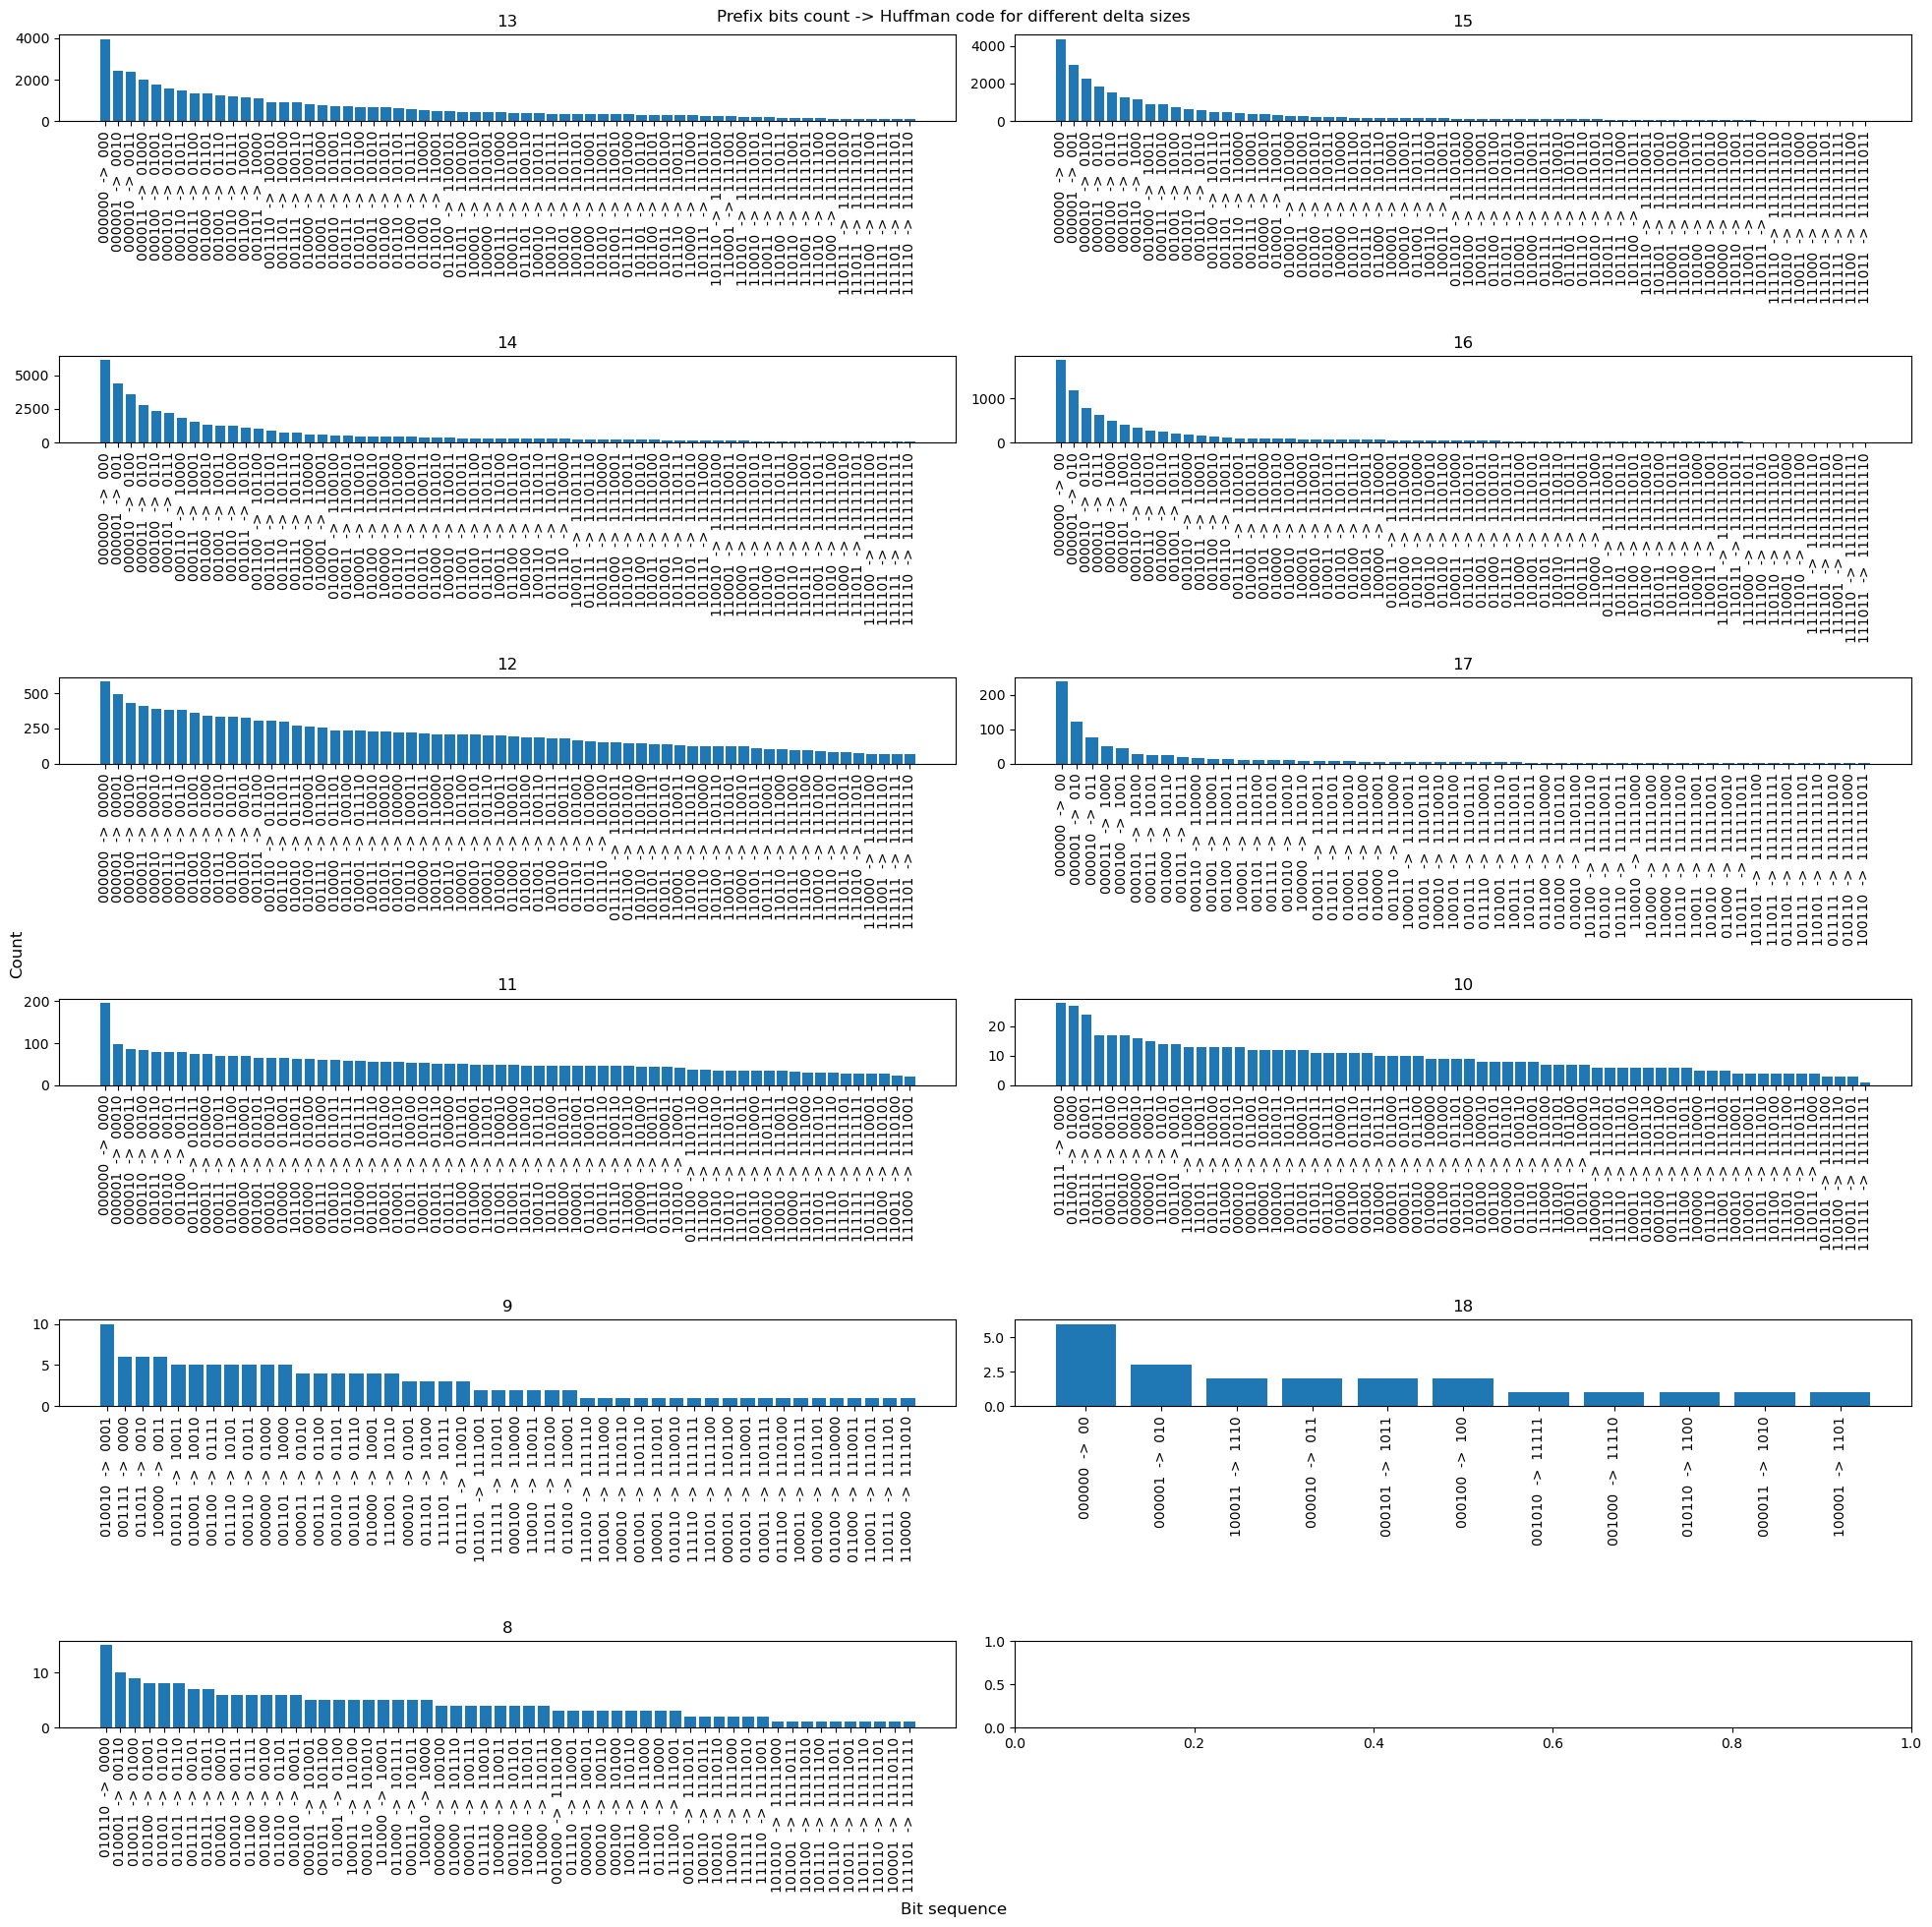

In [37]:
import warnings
warnings.filterwarnings('ignore')


def plot_prefix_frequency(gbc, bcpos):
    #Plot global data
    dictionary = dict(sorted(global_bit_counts.items(), key=lambda x:-x[1]))
    global_codes = get_entropy_codes(global_bit_counts)

    plt.figure(figsize=(20,6))
    plt.bar(dictionary.keys(), dictionary.values())
    plt.title("Global prefix bits count -> Huffman codes")
    plt.xlabel("Bit sequence")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    locs, labels = plt.xticks()  # Get the current locations and labels.
    plt.xticks(locs, ["{}  ->  {}".format(key,global_codes[key].to01()) for key in dictionary.keys()], rotation = 90)
    plt.tight_layout()
    plt.show()

    #Plot delta size specific data
    fig, axs = plt.subplots(len(bit_counts_per_opt_size) // 2 + 1, 2, sharex=False, sharey=False)
    for idx, opt_delta in tqdm.tqdm(enumerate(bit_counts_per_opt_size)):
        dictionary = dict(sorted(bit_counts_per_opt_size[opt_delta].items(), key=lambda x:-x[1]))
        codes = get_entropy_codes(dictionary)
        axs[idx // 2,idx % 2].bar(dictionary.keys(), dictionary.values())
        axs[idx // 2,idx % 2].set_title(opt_delta)        
        axs[idx // 2,idx % 2].set_xticklabels(["{}  ->  {}".format(key,codes[key].to01()) for key in dictionary.keys()], rotation = 90)
    
    fig.suptitle("Prefix bits count -> Huffman code for different delta sizes")
    fig.supylabel('Count')
    fig.supxlabel('Bit sequence')
    fig.tight_layout()
    fig.set_figheight(20)
    fig.set_figwidth(20)

    plt.tight_layout()
    plt.show()

plot_prefix_frequency(global_bit_counts,bit_counts_per_opt_size)


In [84]:
def get_prefix_decrease(codes, bit_count, header = ""):
    original = sum([bit_count[key] * PREFIX_LENGTH for key in bit_count])
    entropy_encoded = sum([bit_count[key] * len(codes[key]) for key in bit_count])
    print(header, "\t\toriginal size  = ",  original, "bits\t\tentropy encoded size  = ", entropy_encoded, "bits\t\t%  = ", entropy_encoded/original)
    return original, entropy_encoded
"Optimal size ", opt_size


global_original_prefix_size, global_entropy_encoded_size = get_prefix_decrease(get_entropy_codes(global_bit_counts), global_bit_counts, "GLOBAL\t")

print("\nUsing global + optimal size specific entropy codes\n--------------------------------------------------\n")
for opt_size in dict(sorted(bit_counts_per_opt_size.items(), key=lambda x:x[0])):
    dictionary = bit_counts_per_opt_size[opt_size]
    original_prefix_size, entropy_encoded_size = get_prefix_decrease(get_entropy_codes(dictionary), dictionary, "Optimal delta length   {}".format(opt_size))

print("\nUsing global specific entropy codes\n--------------------------------------------------\n")
for opt_size in dict(sorted(bit_counts_per_opt_size.items(), key=lambda x:x[0])):
    dictionary = bit_counts_per_opt_size[opt_size]
    original_prefix_size, entropy_encoded_size = get_prefix_decrease(get_entropy_codes(global_bit_counts), dictionary, "Optimal delta length   {}".format(opt_size))


GLOBAL	 		original size  =  854934 bits		entropy encoded size  =  744461 bits		%  =  0.8707818381301948

Using global + optimal size specific entropy codes
--------------------------------------------------

Optimal delta length   8 		original size  =  1404 bits		entropy encoded size  =  1301 bits		%  =  0.9266381766381766
Optimal delta length   9 		original size  =  780 bits		entropy encoded size  =  677 bits		%  =  0.867948717948718
Optimal delta length   10 		original size  =  3684 bits		entropy encoded size  =  3578 bits		%  =  0.9712269272529859
Optimal delta length   11 		original size  =  20118 bits		entropy encoded size  =  19770 bits		%  =  0.9827020578586341
Optimal delta length   12 		original size  =  81138 bits		entropy encoded size  =  78878 bits		%  =  0.9721462200202124
Optimal delta length   13 		original size  =  259146 bits		entropy encoded size  =  236483 bits		%  =  0.9125473671212366
Optimal delta length   14 		original size  =  270084 bits		entropy encoded size  